# YOLO v1

## Paper re-implementation of [YOLO-v1](https://arxiv.org/abs/1506.02640)

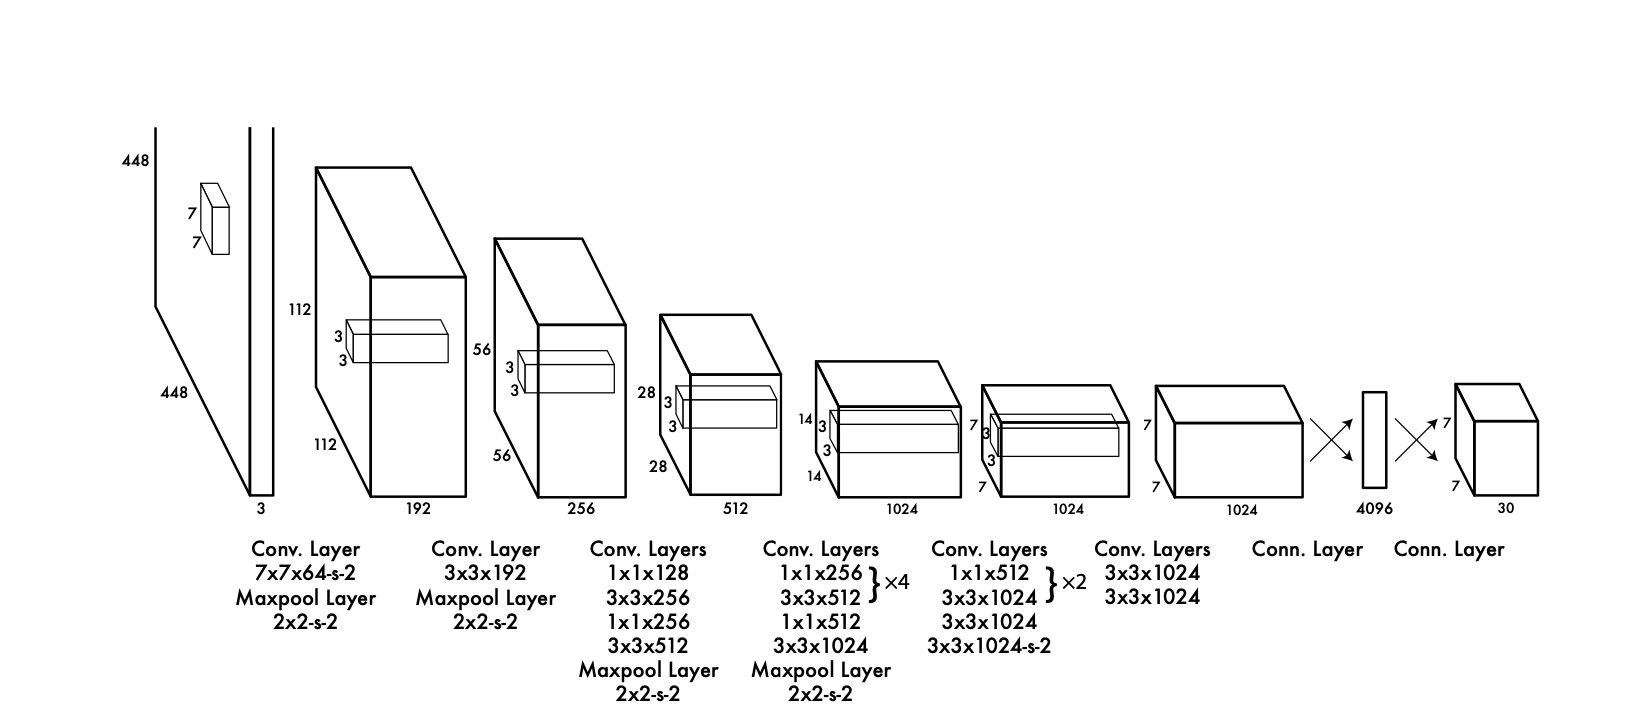

- YOLOv1 divides the input image into an S × S grid. If the center of an object falls into a grid cell, that grid cell is responsible for detecting that object.
- YOLOv1 models detection as a regression problem. It divides the image into an S × S grid and for each grid cell predicts B bounding boxes, confidence for those boxes, and C class probabilities. These predictions are encoded as an S × S × (B ∗ 5 + C) tensor.
    - For evaluating YOLO on PASCAL VOC, it use S = 7, B = 2. PASCAL VOC has 20 labelled classes so C = 20. the final prediction is a 7 × 7 × 30 tensor.
    - Each bounding box consists of 5 predictions: x, y, w, h, and confidence. The `(x, y)` coordinates represent the center of the box relative to the bounds of the grid cell. The `w` and `h` are predicted relative to the whole image. Finally the confidence prediction represents the IOU between the predicted box and any ground truth box.
    - Each grid cell also predicts C conditional class probabilities, $Pr(Classi|Object)$. These probabilities are conditioned on the grid cell containing an object. v1 only predict one set of class probabilities per grid cell, regardless of the number of boxes B.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class Squeeze(nn.Module):
    def __init__(self):
        super(Squeeze, self).__init__()

    def forward(self, x):
        return x.squeeze()

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)

In [3]:
class DarkNet(nn.Module):
    def __init__(self, conv_only=False, bn=True, init_weight=True):
        super(DarkNet, self).__init__()

        # Make layers
        self.features = self._make_conv_bn_layers() if bn else self._make_conv_layers()
        if not conv_only:
            self.fc = self._make_fc_layers()

        # Initialize weights
        if init_weight:
            self._initialize_weights()

        self.conv_only = conv_only

    def forward(self, x):
        x = self.features(x)
        if not self.conv_only:
            x = self.fc(x)
        return x

    def _make_conv_bn_layers(self):
        conv = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(192, 128, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 256, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(512, 256, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 256, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 256, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 256, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 512, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(1024, 512, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(1024, 512, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True)
        )
        return conv

    def _make_conv_layers(self):
        conv = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=2, padding=3),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 192, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(192, 128, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 256, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(512, 256, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 256, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 256, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 256, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 512, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(1024, 512, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(1024, 512, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        return conv

    def _make_fc_layers(self):
        fc = nn.Sequential(
            nn.AvgPool2d(7),
            Squeeze(),
            nn.Linear(1024, 1000)
        )
        return fc

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [4]:
class YOLOv1(nn.Module):
    def __init__(self, features, num_bboxes=2, num_classes=20, bn=True):
        super(YOLOv1, self).__init__()

        self.feature_size = 7
        self.num_bboxes = num_bboxes
        self.num_classes = num_classes

        self.features = features
        self.conv_layers = self._make_conv_layers(bn)
        self.fc_layers = self._make_fc_layers()

    def _make_conv_layers(self, bn):
        if not bn:
            net = nn.Sequential(
                nn.Conv2d(1024, 1024, 3, padding=1),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Conv2d(1024, 1024, 3, stride=2, padding=1),
                nn.LeakyReLU(0.1),

                nn.Conv2d(1024, 1024, 3, padding=1),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Conv2d(1024, 1024, 3, padding=1),
                nn.LeakyReLU(0.1, inplace=True)
            )

        else:
            net = nn.Sequential(
                nn.Conv2d(1024, 1024, 3, padding=1),
                nn.BatchNorm2d(1024),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Conv2d(1024, 1024, 3, stride=2, padding=1),
                nn.BatchNorm2d(1024),
                nn.LeakyReLU(0.1),

                nn.Conv2d(1024, 1024, 3, padding=1),
                nn.BatchNorm2d(1024),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Conv2d(1024, 1024, 3, padding=1),
                nn.BatchNorm2d(1024),
                nn.LeakyReLU(0.1, inplace=True)
            )

        return net

    def _make_fc_layers(self):
        S, B, C = self.feature_size, self.num_bboxes, self.num_classes

        net = nn.Sequential(
            Flatten(),
            nn.Linear(7 * 7 * 1024, 4096),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.5, inplace=False), # is it okay to use Dropout with BatchNorm?
            nn.Linear(4096, S * S * (5 * B + C)),
            nn.Sigmoid()
        )

        return net

    def forward(self, x):
        S, B, C = self.feature_size, self.num_bboxes, self.num_classes

        x = self.features(x)
        x = self.conv_layers(x)
        x = self.fc_layers(x)

        x = x.view(-1, S, S, 5 * B + C)
        return x

In [5]:
def test():
    from torch.autograd import Variable

    # Build model with randomly initialized weights
    darknet = DarkNet(conv_only=True, bn=True, init_weight=True)
    yolo = YOLOv1(darknet.features)

    # Prepare a dummy image to input
    image = torch.rand(10, 3, 448, 448)
    image = Variable(image)

    # Forward
    output = yolo(image)
    # Check ouput tensor size, which should be [10, 7, 7, 30]
    print(output.size())
    
test()

torch.Size([10, 7, 7, 30])


In [6]:
from torchsummary import summary

darknet = DarkNet(conv_only=True, bn=True, init_weight=True)

summary(YOLOv1(darknet.features),(3,448,448))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           9,472
       BatchNorm2d-2         [-1, 64, 224, 224]             128
         LeakyReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5        [-1, 192, 112, 112]         110,784
       BatchNorm2d-6        [-1, 192, 112, 112]             384
         LeakyReLU-7        [-1, 192, 112, 112]               0
         MaxPool2d-8          [-1, 192, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]          24,704
      BatchNorm2d-10          [-1, 128, 56, 56]             256
        LeakyReLU-11          [-1, 128, 56, 56]               0
           Conv2d-12          [-1, 256, 56, 56]         295,168
      BatchNorm2d-13          [-1, 256, 56, 56]             512
        LeakyReLU-14          [-1, 256,

## Loss

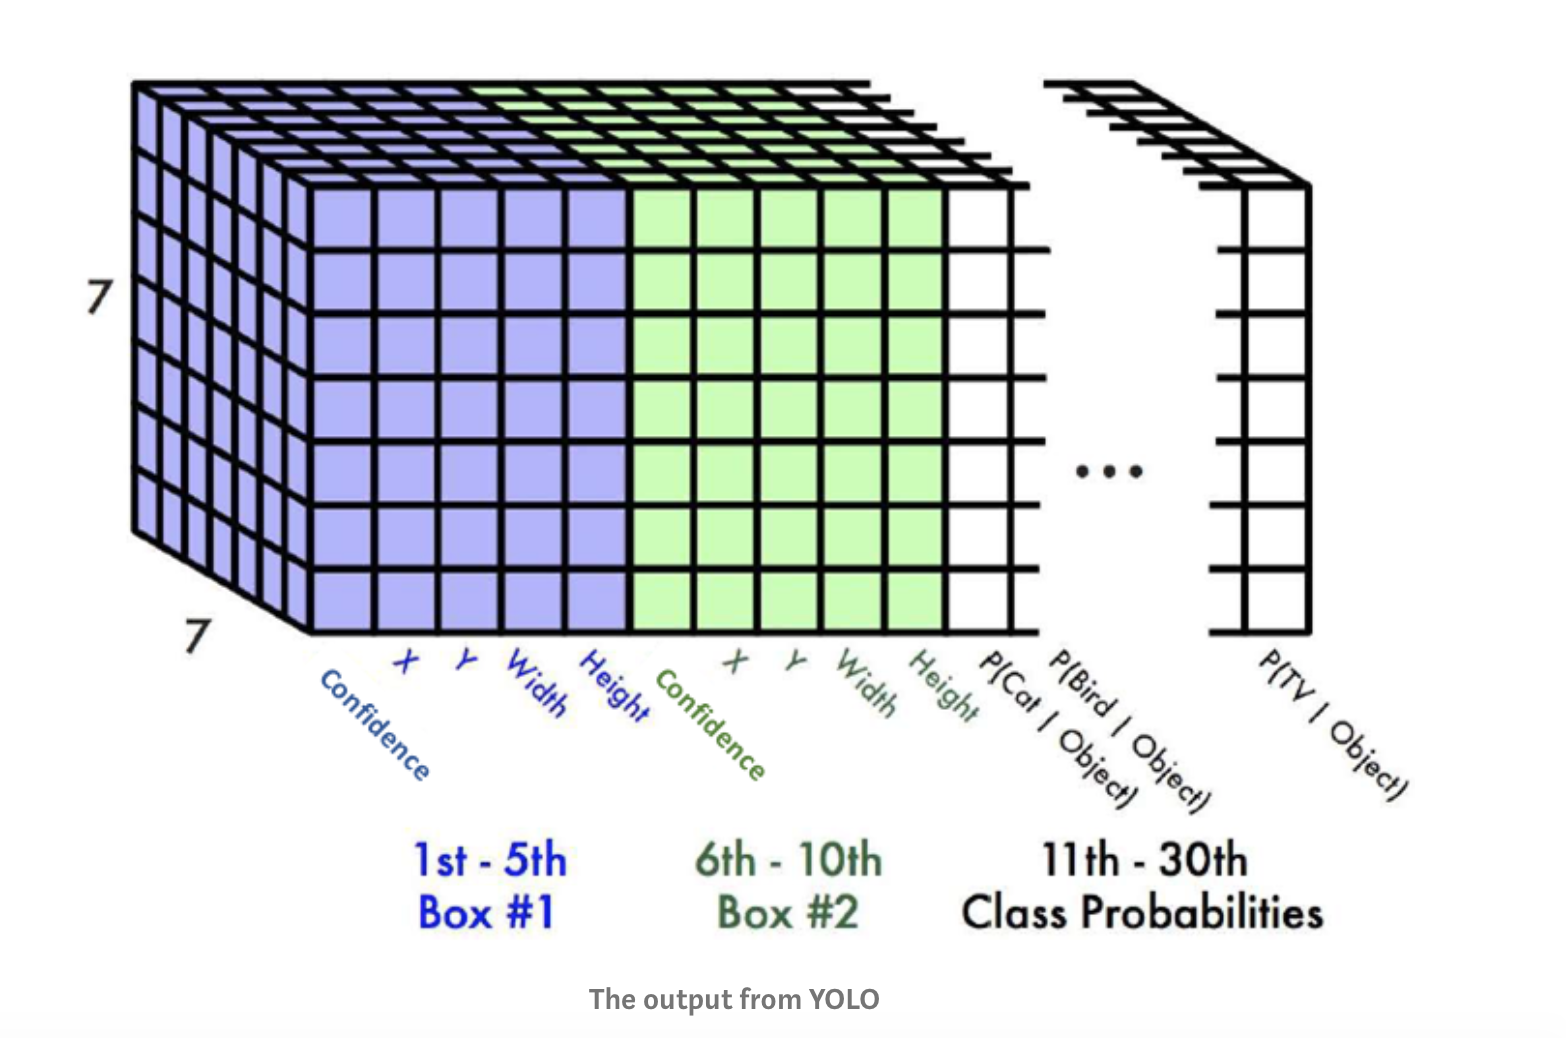

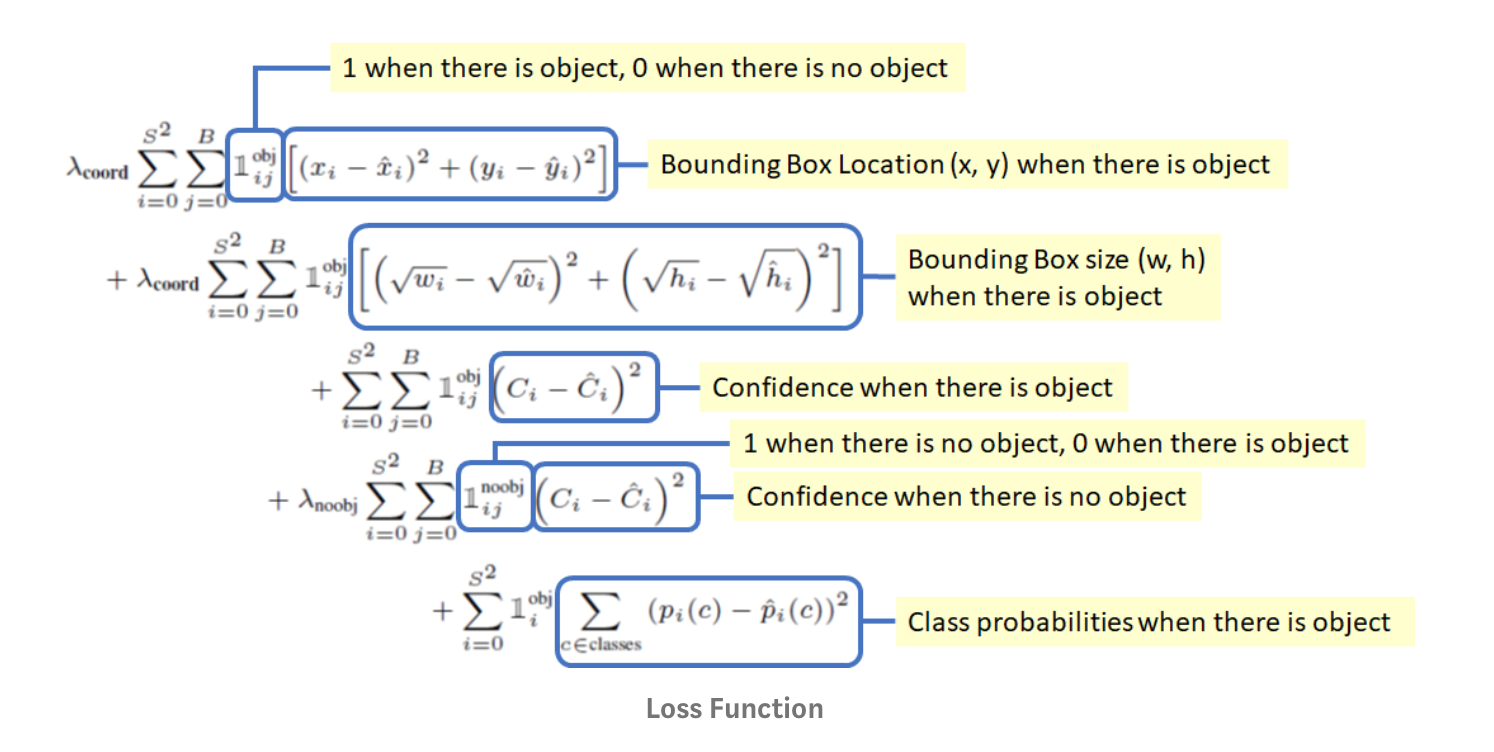

1. 1st term `(x, y)`: The bounding box x and y coordinates is parametrized to be offsets of a particular grid cell location so they are also bounded between 0 and 1. And the sum of square error (SSE) is estimated only when there is object.
2. 2nd term `(w, h)`: The bounding box width and height are normalized by the image width and height so that they fall between 0 and 1. SSE is estimated only when there is object. Since small deviations in large boxes matter less than in small boxes. square root of the bounding box width w and height h instead of the width and height directly to partially address this problem.
3. 3rd term and 4th term (The confidence) (i.e. the IOU between the predicted box and any ground truth box): In every image many grid cells do not contain any object. This pushes the “confidence” scores of those cells towards zero, often overpowering the gradient from cells that do contain objects, and makes the model unstable. Thus, the loss from confidence predictions for boxes that don’t contain objects, is decreased, i.e. λnoobj=0.5.
4. 5th term (Class Probabilities): SSE of class probabilities when there is objects.
6. $\lambda_{coord}$: Due to the same reason mentioned in 3rd and 4th terms, λcoord = 5 to increase the loss from bounding box coordinate predictions.

In [7]:
class Loss(nn.Module):

    def __init__(self, feature_size=7, num_bboxes=2, num_classes=20, lambda_coord=5.0, lambda_noobj=0.5):
        """ Constructor.
        Args:
            feature_size: (int) size of input feature map.
            num_bboxes: (int) number of bboxes per each cell.
            num_classes: (int) number of the object classes.
            lambda_coord: (float) weight for bbox location/size losses.
            lambda_noobj: (float) weight for no-objectness loss.
        """
        super(Loss, self).__init__()

        self.S = feature_size
        self.B = num_bboxes
        self.C = num_classes
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj


    def compute_iou(self, bbox1, bbox2):
        """ Compute the IoU (Intersection over Union) of two set of bboxes, each bbox format: [x1, y1, x2, y2].
        Args:
            bbox1: (Tensor) bounding bboxes, sized [N, 4].
            bbox2: (Tensor) bounding bboxes, sized [M, 4].
        Returns:
            (Tensor) IoU, sized [N, M].
        """
        N = bbox1.size(0)
        M = bbox2.size(0)

        # Compute left-top coordinate of the intersections
        lt = torch.max(
            bbox1[:, :2].unsqueeze(1).expand(N, M, 2), # [N, 2] -> [N, 1, 2] -> [N, M, 2]
            bbox2[:, :2].unsqueeze(0).expand(N, M, 2)  # [M, 2] -> [1, M, 2] -> [N, M, 2]
        )
        # Conpute right-bottom coordinate of the intersections
        rb = torch.min(
            bbox1[:, 2:].unsqueeze(1).expand(N, M, 2), # [N, 2] -> [N, 1, 2] -> [N, M, 2]
            bbox2[:, 2:].unsqueeze(0).expand(N, M, 2)  # [M, 2] -> [1, M, 2] -> [N, M, 2]
        )
        # Compute area of the intersections from the coordinates
        wh = rb - lt   # width and height of the intersection, [N, M, 2]
        wh[wh < 0] = 0 # clip at 0
        inter = wh[:, :, 0] * wh[:, :, 1] # [N, M]

        # Compute area of the bboxes
        area1 = (bbox1[:, 2] - bbox1[:, 0]) * (bbox1[:, 3] - bbox1[:, 1]) # [N, ]
        area2 = (bbox2[:, 2] - bbox2[:, 0]) * (bbox2[:, 3] - bbox2[:, 1]) # [M, ]
        area1 = area1.unsqueeze(1).expand_as(inter) # [N, ] -> [N, 1] -> [N, M]
        area2 = area2.unsqueeze(0).expand_as(inter) # [M, ] -> [1, M] -> [N, M]

        # Compute IoU from the areas
        union = area1 + area2 - inter # [N, M, 2]
        iou = inter / union           # [N, M, 2]

        return iou

    def forward(self, pred_tensor, target_tensor):
        """ Compute loss for YOLO training.
        Args:
            pred_tensor: (Tensor) predictions, sized [n_batch, S, S, Bx5+C], 5=len([x, y, w, h, conf]).
            target_tensor: (Tensor) targets, sized [n_batch, S, S, Bx5+C].
        Returns:
            (Tensor): loss, sized [1, ].
        """
        # TODO: Romove redundant dimensions for some Tensors.

        S, B, C = self.S, self.B, self.C
        N = 5 * B + C    # 5=len([x, y, w, h, conf]

        batch_size = pred_tensor.size(0)
        coord_mask = target_tensor[:, :, :, 4] > 0  # mask for the cells which contain objects. [n_batch, S, S]
        noobj_mask = target_tensor[:, :, :, 4] == 0 # mask for the cells which do not contain objects. [n_batch, S, S]
        coord_mask = coord_mask.unsqueeze(-1).expand_as(target_tensor) # [n_batch, S, S] -> [n_batch, S, S, N]
        noobj_mask = noobj_mask.unsqueeze(-1).expand_as(target_tensor) # [n_batch, S, S] -> [n_batch, S, S, N]

        coord_pred = pred_tensor[coord_mask].view(-1, N)            # pred tensor on the cells which contain objects. [n_coord, N]
                                                                    # n_coord: number of the cells which contain objects.
        bbox_pred = coord_pred[:, :5*B].contiguous().view(-1, 5)    # [n_coord x B, 5=len([x, y, w, h, conf])]
        class_pred = coord_pred[:, 5*B:]                            # [n_coord, C]

        coord_target = target_tensor[coord_mask].view(-1, N)        # target tensor on the cells which contain objects. [n_coord, N]
                                                                    # n_coord: number of the cells which contain objects.
        bbox_target = coord_target[:, :5*B].contiguous().view(-1, 5)# [n_coord x B, 5=len([x, y, w, h, conf])]
        class_target = coord_target[:, 5*B:]                        # [n_coord, C]

        # Compute loss for the cells with no object bbox.
        noobj_pred = pred_tensor[noobj_mask].view(-1, N)        # pred tensor on the cells which do not contain objects. [n_noobj, N]
                                                                # n_noobj: number of the cells which do not contain objects.
        noobj_target = target_tensor[noobj_mask].view(-1, N)    # target tensor on the cells which do not contain objects. [n_noobj, N]
                                                                # n_noobj: number of the cells which do not contain objects.
        noobj_conf_mask = torch.cuda.ByteTensor(noobj_pred.size()).fill_(0) # [n_noobj, N]
        for b in range(B):
            noobj_conf_mask[:, 4 + b*5] = 1 # noobj_conf_mask[:, 4] = 1; noobj_conf_mask[:, 9] = 1
        noobj_pred_conf = noobj_pred[noobj_conf_mask]       # [n_noobj, 2=len([conf1, conf2])]
        noobj_target_conf = noobj_target[noobj_conf_mask]   # [n_noobj, 2=len([conf1, conf2])]
        loss_noobj = F.mse_loss(noobj_pred_conf, noobj_target_conf, reduction='sum')

        # Compute loss for the cells with objects.
        coord_response_mask = torch.cuda.ByteTensor(bbox_target.size()).fill_(0)    # [n_coord x B, 5]
        coord_not_response_mask = torch.cuda.ByteTensor(bbox_target.size()).fill_(1)# [n_coord x B, 5]
        bbox_target_iou = torch.zeros(bbox_target.size()).cuda()                    # [n_coord x B, 5], only the last 1=(conf,) is used

        # Choose the predicted bbox having the highest IoU for each target bbox.
        for i in range(0, bbox_target.size(0), B):
            pred = bbox_pred[i:i+B] # predicted bboxes at i-th cell, [B, 5=len([x, y, w, h, conf])]
            pred_xyxy = Variable(torch.FloatTensor(pred.size())) # [B, 5=len([x1, y1, x2, y2, conf])]
            # Because (center_x,center_y)=pred[:, 2] and (w,h)=pred[:,2:4] are normalized for cell-size and image-size respectively,
            # rescale (center_x,center_y) for the image-size to compute IoU correctly.
            pred_xyxy[:,  :2] = pred[:, 2]/float(S) - 0.5 * pred[:, 2:4]
            pred_xyxy[:, 2:4] = pred[:, 2]/float(S) + 0.5 * pred[:, 2:4]

            target = bbox_target[i] # target bbox at i-th cell. Because target boxes contained by each cell are identical in current implementation, enough to extract the first one.
            target = bbox_target[i].view(-1, 5) # target bbox at i-th cell, [1, 5=len([x, y, w, h, conf])]
            target_xyxy = Variable(torch.FloatTensor(target.size())) # [1, 5=len([x1, y1, x2, y2, conf])]
            # Because (center_x,center_y)=target[:, 2] and (w,h)=target[:,2:4] are normalized for cell-size and image-size respectively,
            # rescale (center_x,center_y) for the image-size to compute IoU correctly.
            target_xyxy[:,  :2] = target[:, 2]/float(S) - 0.5 * target[:, 2:4]
            target_xyxy[:, 2:4] = target[:, 2]/float(S) + 0.5 * target[:, 2:4]

            iou = self.compute_iou(pred_xyxy[:, :4], target_xyxy[:, :4]) # [B, 1]
            max_iou, max_index = iou.max(0)
            max_index = max_index.data.cuda()

            coord_response_mask[i+max_index] = 1
            coord_not_response_mask[i+max_index] = 0

            # "we want the confidence score to equal the intersection over union (IOU) between the predicted box and the ground truth"
            # from the original paper of YOLO.
            bbox_target_iou[i+max_index, torch.LongTensor([4]).cuda()] = (max_iou).data.cuda()
        bbox_target_iou = Variable(bbox_target_iou).cuda()

        # BBox location/size and objectness loss for the response bboxes.
        bbox_pred_response = bbox_pred[coord_response_mask].view(-1, 5)      # [n_response, 5]
        bbox_target_response = bbox_target[coord_response_mask].view(-1, 5)  # [n_response, 5], only the first 4=(x, y, w, h) are used
        target_iou = bbox_target_iou[coord_response_mask].view(-1, 5)        # [n_response, 5], only the last 1=(conf,) is used
        loss_xy = F.mse_loss(bbox_pred_response[:, :2], bbox_target_response[:, :2], reduction='sum')
        loss_wh = F.mse_loss(torch.sqrt(bbox_pred_response[:, 2:4]), torch.sqrt(bbox_target_response[:, 2:4]), reduction='sum')
        loss_obj = F.mse_loss(bbox_pred_response[:, 4], target_iou[:, 4], reduction='sum')

        # Class probability loss for the cells which contain objects.
        loss_class = F.mse_loss(class_pred, class_target, reduction='sum')

        # Total loss
        loss = self.lambda_coord * (loss_xy + loss_wh) + loss_obj + self.lambda_noobj * loss_noobj + loss_class
        loss = loss / float(batch_size)

        return loss

In [9]:
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable

from voc import VOCDataset
from darknet import DarkNet
from yolo_v1 import YOLOv1
from loss import Loss

import os
import numpy as np
import math
from datetime import datetime

from tensorboardX import SummaryWriter


# Check if GPU devices are available.
use_gpu = torch.cuda.is_available()
assert use_gpu, 'Current implementation does not support CPU mode. Enable CUDA.'
print('CUDA current_device: {}'.format(torch.cuda.current_device()))
print('CUDA device_count: {}'.format(torch.cuda.device_count()))

# Path to data dir.
image_dir = 'data/VOC_allimgs/'

# Path to label files.
train_label = ('data/voc2007.txt', 'data/voc2012.txt')
val_label = 'data/voc2007test.txt'

# Path to checkpoint file containing pre-trained DarkNet weight.
checkpoint_path = 'weights/darknet/model_best.pth.tar'

# Frequency to print/log the results.
print_freq = 5
tb_log_freq = 5

# Training hyper parameters.
init_lr = 0.001
base_lr = 0.01
momentum = 0.9
weight_decay = 5.0e-4
num_epochs = 135
batch_size = 64

# Learning rate scheduling.
def update_lr(optimizer, epoch, burnin_base, burnin_exp=4.0):
    if epoch == 0:
        lr = init_lr + (base_lr - init_lr) * math.pow(burnin_base, burnin_exp)
    elif epoch == 1:
        lr = base_lr
    elif epoch == 75:
        lr = 0.001
    elif epoch == 105:
        lr = 0.0001
    else:
        return

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# Load pre-trained darknet.
darknet = DarkNet(conv_only=True, bn=True, init_weight=True)
darknet.features = torch.nn.DataParallel(darknet.features)

src_state_dict = torch.load(checkpoint_path)['state_dict']
dst_state_dict = darknet.state_dict()

for k in dst_state_dict.keys():
    print('Loading weight of', k)
    dst_state_dict[k] = src_state_dict[k]
darknet.load_state_dict(dst_state_dict)

# Load YOLO model.
yolo = YOLOv1(darknet.features)
yolo.conv_layers = torch.nn.DataParallel(yolo.conv_layers)
yolo.cuda()

# Setup loss and optimizer.
criterion = Loss(feature_size=yolo.feature_size)
optimizer = torch.optim.SGD(yolo.parameters(), lr=init_lr, momentum=momentum, weight_decay=weight_decay)

# Load Pascal-VOC dataset.
train_dataset = VOCDataset(True, image_dir, train_label)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

val_dataset = VOCDataset(False, image_dir, val_label)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print('Number of training images: ', len(train_dataset))

# Open TensorBoardX summary writer
log_dir = datetime.now().strftime('%b%d_%H-%M-%S')
log_dir = os.path.join('results/yolo', log_dir)
writer = SummaryWriter(log_dir=log_dir)

# Training loop.
logfile = open(os.path.join(log_dir, 'log.txt'), 'w')
best_val_loss = np.inf

for epoch in range(num_epochs):
    print('\n')
    print('Starting epoch {} / {}'.format(epoch, num_epochs))

    # Training.
    yolo.train()
    total_loss = 0.0
    total_batch = 0

    for i, (imgs, targets) in enumerate(train_loader):
        # Update learning rate.
        update_lr(optimizer, epoch, float(i) / float(len(train_loader) - 1))
        lr = get_lr(optimizer)

        # Load data as a batch.
        batch_size_this_iter = imgs.size(0)
        imgs = Variable(imgs)
        targets = Variable(targets)
        imgs, targets = imgs.cuda(), targets.cuda()

        # Forward to compute loss.
        preds = yolo(imgs)
        loss = criterion(preds, targets)
        loss_this_iter = loss.item()
        total_loss += loss_this_iter * batch_size_this_iter
        total_batch += batch_size_this_iter

        # Backward to update model weight.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print current loss.
        if i % print_freq == 0:
            print('Epoch [%d/%d], Iter [%d/%d], LR: %.6f, Loss: %.4f, Average Loss: %.4f'
            % (epoch, num_epochs, i, len(train_loader), lr, loss_this_iter, total_loss / float(total_batch)))

        # TensorBoard.
        n_iter = epoch * len(train_loader) + i
        if n_iter % tb_log_freq == 0:
            writer.add_scalar('train/loss', loss_this_iter, n_iter)
            writer.add_scalar('lr', lr, n_iter)

    # Validation.
    yolo.eval()
    val_loss = 0.0
    total_batch = 0

    for i, (imgs, targets) in enumerate(val_loader):
        # Load data as a batch.
        batch_size_this_iter = imgs.size(0)
        imgs = Variable(imgs)
        targets = Variable(targets)
        imgs, targets = imgs.cuda(), targets.cuda()

        # Forward to compute validation loss.
        with torch.no_grad():
            preds = yolo(imgs)
        loss = criterion(preds, targets)
        loss_this_iter = loss.item()
        val_loss += loss_this_iter * batch_size_this_iter
        total_batch += batch_size_this_iter
    val_loss /= float(total_batch)

    # Save results.
    logfile.writelines(str(epoch + 1) + '\t' + str(val_loss) + '\n')
    logfile.flush()
    torch.save(yolo.state_dict(), os.path.join(log_dir, 'model_latest.pth'))
    if best_val_loss > val_loss:
        best_val_loss = val_loss
        torch.save(yolo.state_dict(), os.path.join(log_dir, 'model_best.pth'))

    # Print.
    print('Epoch [%d/%d], Val Loss: %.4f, Best Val Loss: %.4f'
    % (epoch + 1, num_epochs, val_loss, best_val_loss))

    # TensorBoard.
    writer.add_scalar('test/loss', val_loss, epoch + 1)

writer.close()
logfile.close()

## Reference
- https://towardsdatascience.com/yolov1-you-only-look-once-object-detection-e1f3ffec8a89
